In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix


plt.style.use('fivethirtyeight')

In [2]:
ROOT_DIR = 'MNIST'

train_data = datasets.MNIST(
    root = ROOT_DIR,
    train = True,
    transform = transforms.ToTensor(),
    target_transform = None,
    download = True   

)

test_data = datasets.MNIST(
    root = ROOT_DIR,
    train = False,
    transform = transforms.ToTensor(),
    target_transform = None,
    download = True   

)

Files already downloaded
Files already downloaded


In [3]:
train_data.train_data.dtype

torch.uint8

In [4]:
test_data.test_data.dtype

torch.uint8

In [5]:
train_data.train_labels

tensor([5, 0, 4,  ..., 5, 6, 8])

<AxesSubplot:>

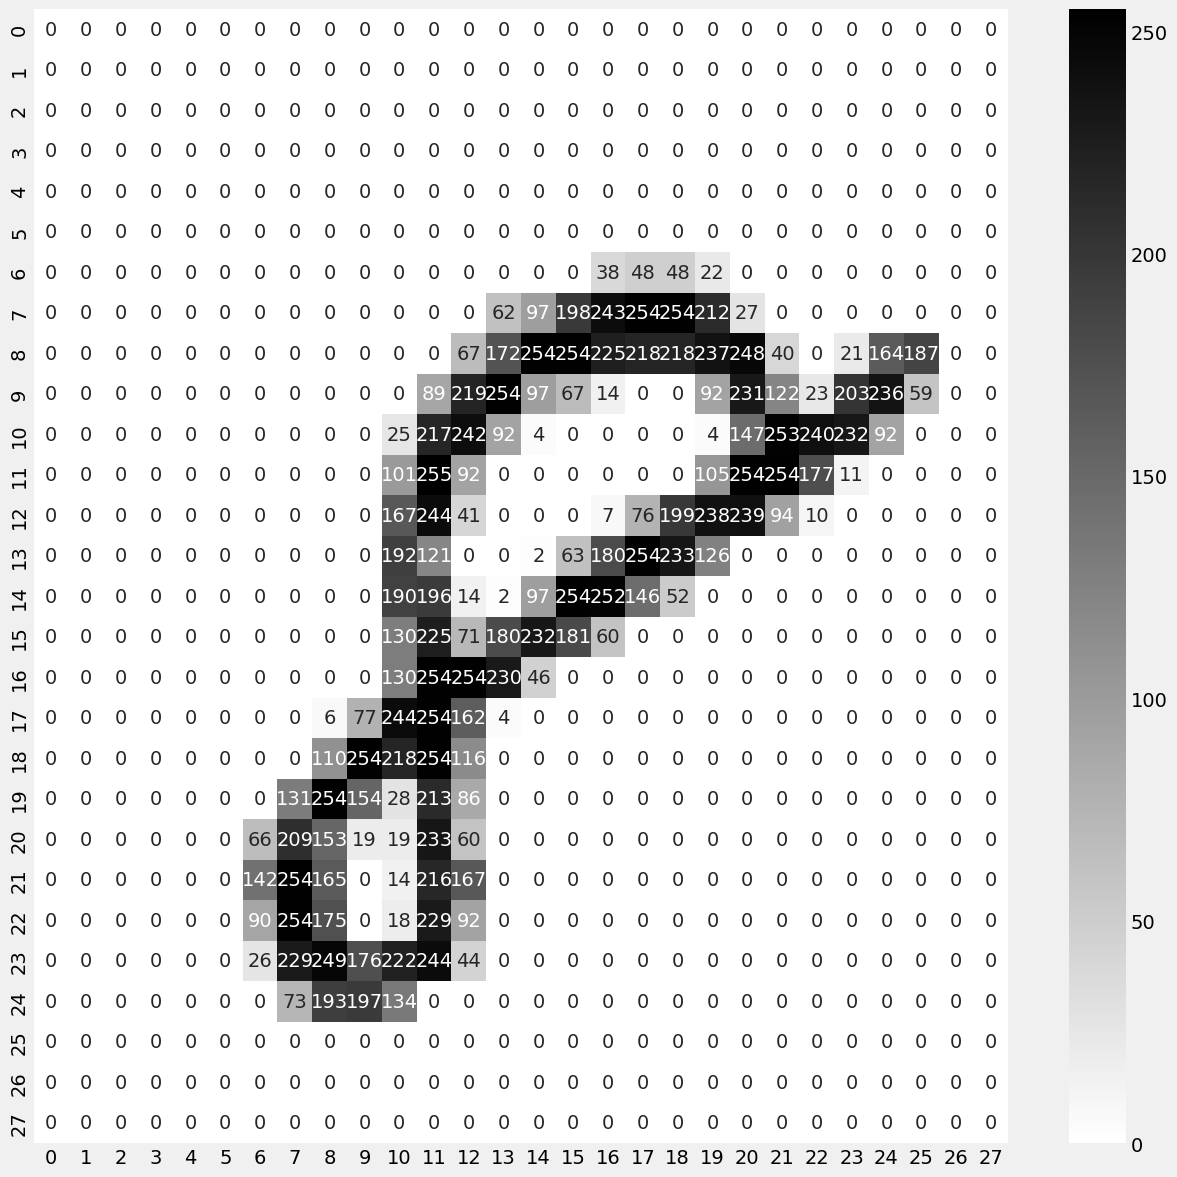

In [6]:
plt.figure(figsize=(14,14))
sns.heatmap(train_data.train_data[-1],cmap='binary',fmt='d',annot=True)

In [7]:
train_data.train_data.shape

torch.Size([60000, 28, 28])

In [8]:
BATCH=128

train_data_loader=DataLoader(
                    dataset=train_data,
                    batch_size=BATCH,
                    shuffle=True,
                    
)


test_data_loader=DataLoader(
                    dataset=test_data,
                    batch_size=BATCH,
                    
)




In [27]:
for x in train_data_loader:
    print(x[0].shape)
    break

torch.Size([128, 1, 28, 28])


In [35]:
for batch, data in enumerate(train_data_loader):
    if batch==467:
        print(data[0].shape)
        


torch.Size([128, 1, 28, 28])


In [14]:
DEVICE='cuda' if torch.cuda.is_available() else "cpu"

In [15]:
DEVICE

'cuda'

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self,in_,out_):
        super().__init__()
        self.layers=nn.Sequential(
            nn.Linear(in_,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,out_)
        )
    def forward(self,x):
        return self.layers(x)
    

In [24]:
model=NeuralNetwork(784,10)
model.to(DEVICE)

model

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [36]:
CE_loss=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())

In [46]:
EPOCHS = 10
loss_ = list()
acc_ = list()


for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    for batch, data in enumerate(train_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)
        
        optimizer.zero_grad()
        
        y_pred = model(x.reshape(-1, 784))
        
        loss = CE_loss(y_pred, y)
        
        
        loss_.append(loss)
        loss.backward()
        optimizer.step()
        
        accuracy = torch.mean((torch.argmax(y_pred, 1) == y).float())
        acc_.append(accuracy)
        
        if batch%100 == 0:
            print(f"   Batch: {batch}, Loss: {loss.item():.4f} Accuracy {accuracy:.4f}")


Epoch: 1/10
   Batch: 0, Loss: 0.0008 Accuracy 1.0000
   Batch: 100, Loss: 0.0003 Accuracy 1.0000
   Batch: 200, Loss: 0.0081 Accuracy 0.9922
   Batch: 300, Loss: 0.0005 Accuracy 1.0000
   Batch: 400, Loss: 0.0077 Accuracy 0.9922
Epoch: 2/10
   Batch: 0, Loss: 0.0006 Accuracy 1.0000
   Batch: 100, Loss: 0.0001 Accuracy 1.0000
   Batch: 200, Loss: 0.0001 Accuracy 1.0000
   Batch: 300, Loss: 0.0004 Accuracy 1.0000
   Batch: 400, Loss: 0.0070 Accuracy 0.9922
Epoch: 3/10
   Batch: 0, Loss: 0.0001 Accuracy 1.0000
   Batch: 100, Loss: 0.0028 Accuracy 1.0000
   Batch: 200, Loss: 0.0001 Accuracy 1.0000
   Batch: 300, Loss: 0.0002 Accuracy 1.0000
   Batch: 400, Loss: 0.0001 Accuracy 1.0000
Epoch: 4/10
   Batch: 0, Loss: 0.0079 Accuracy 1.0000
   Batch: 100, Loss: 0.0016 Accuracy 1.0000
   Batch: 200, Loss: 0.0012 Accuracy 1.0000
   Batch: 300, Loss: 0.0002 Accuracy 1.0000
   Batch: 400, Loss: 0.0003 Accuracy 1.0000
Epoch: 5/10
   Batch: 0, Loss: 0.0064 Accuracy 1.0000
   Batch: 100, Loss: 0.000

<AxesSubplot:>

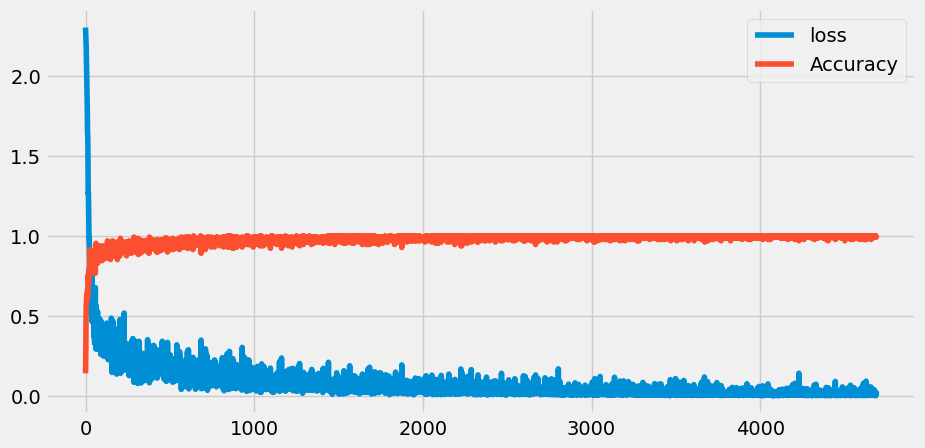

In [38]:
# plot the Train acc and loss
# plt.figure(figsize=(14,14))
pd.DataFrame(data={'loss': loss_, "Accuracy": acc_}).plot(figsize=(10,5))

In [51]:
# testing over the test data

test_loss = 0
test_acc = 0

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)        
        
        y_pred = model(x.reshape(-1, 784))
        loss = CE_loss(y_pred, y)
        
        test_loss += loss.item()
        test_acc += torch.mean((torch.argmax(y_pred, 1) == y).float()).item()

In [52]:
print(f"test loss: {test_loss/batch:.4f}, test accuracy: {test_acc/batch:.4f}")

test loss: 0.1377, test accuracy: 0.9905


In [41]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
    for batch, data in enumerate(test_data_loader):
        x = data[0].to(DEVICE)
        y = data[1].to(DEVICE)        
        
        y_pred = model(x.reshape(-1, 784))
        loss = CE_loss(y_pred, y)
        
        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, y.cpu().numpy()))   

In [42]:
cm = confusion_matrix(target, pred)


<AxesSubplot:>

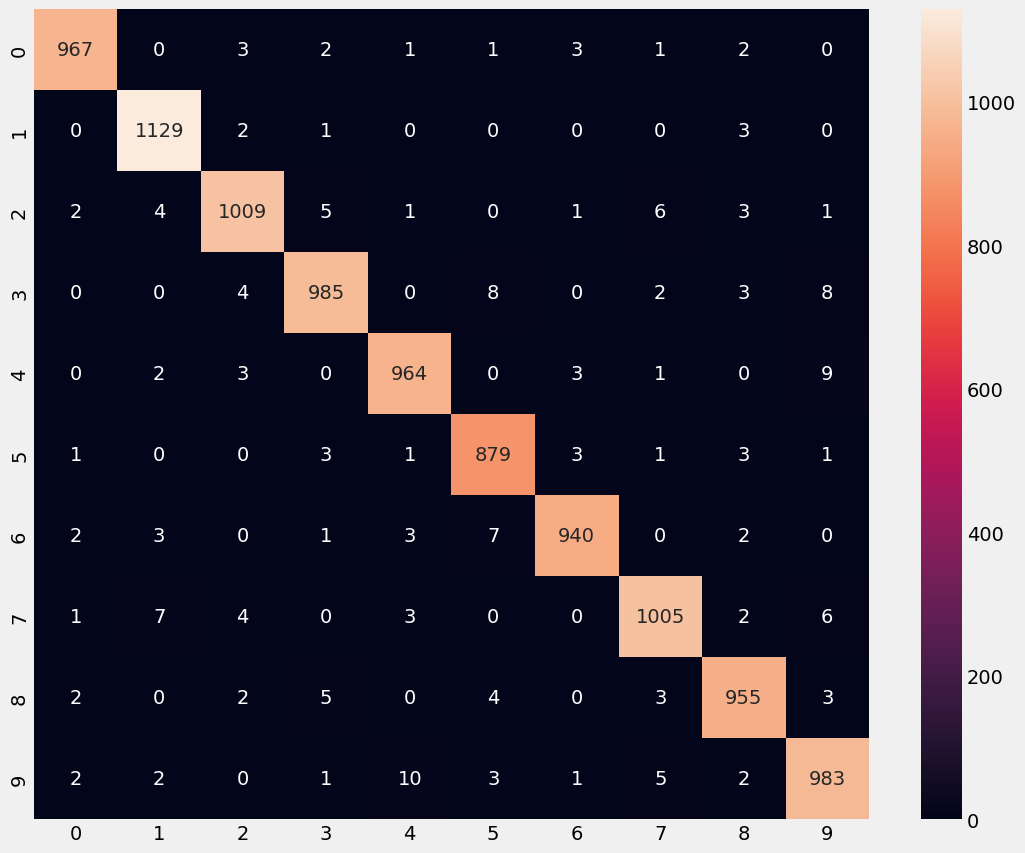

In [43]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d')